<a href="https://colab.research.google.com/github/rfvassallo/ComputerVisonClasses/blob/master/lesson09-rectified_reconstruction/sparse_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16


     |████████████████████████████████| 25.0MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 1.3MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


(256, 2)


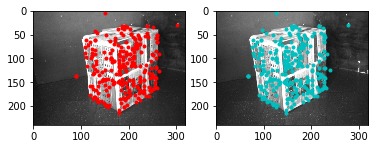

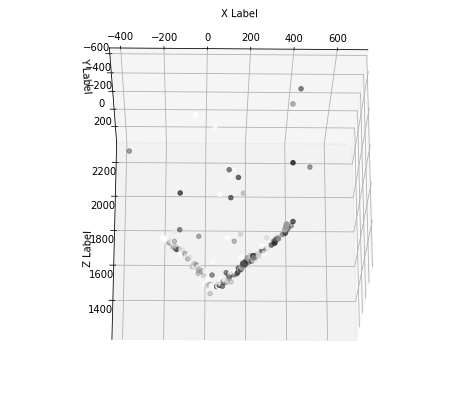

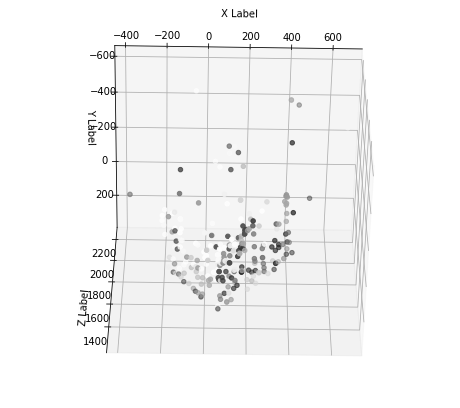

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys


# Return the skew matrix formed from a 3x1 vector 
def skew(vector):
    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])




# Read images
IR = cv2.imread('direita.ppm')  # right image
IL = cv2.imread('esquerda.ppm') # left image


# find the keypoints and descriptors with SIFT

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(IL,None)
kp2, des2 = sift.detectAndCompute(IR,None)

# Solve matching between detected points in both images
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
pts1 = []
pts2 = []

# Select good matches
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):

    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


pts1 = np.asarray(pts1).astype(np.float32)
pts2 = np.asarray(pts2).astype(np.float32)

print(pts1.shape)

xpL = pts1[:,0]
ypL = pts1[:,1]
xpR = pts2[:,0]
ypR = pts2[:,1]


# intrinsic parameter matrix

fm = 403.657593 # Fical distantce in pixels
cx = 161.644318 # Principal point - x-coordinate (pixels) 
cy = 124.202080 # Principal point - y-coordinate (pixels) 
bl = 119.929 # baseline (mm)
# for the right camera    
K_right = np.array([[ fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])
    
# for the left camera
K_left = np.array([[fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

# Extrinsec parameters
# Translation between cameras
T = np.array([-bl, 0, 0]) 
T = T/np.linalg.norm(T)
T_hat = skew(T)
# Rotation
R = np.array([[ 1,0,0],[ 0,1,0],[0,0,1]])



# Elimina as correspondencia erradas, comparando as coordenadas x e y dos
# pares correspondentes


# Como as imagens já são retificadas. i.e., possuem planos paralelos e
# estão na mesma altura, a coordenada y das correspondências devem ser
# iguais. Para considerar influência de ruído, adotou-se no máximo uma
# diferença de 5 pixels;
# Elimina os pontos correspondentes que possuam diferença em y de mais de 5
# pixels

error = np.abs(ypL-ypR)
#good = np.zeros(error.shape)
good = np.where(error < 10)

xpL = xpL[good] 
ypL = ypL[good]
xpR = xpR[good]
ypR = ypR[good]


# Para filtrar ainda mais, assume-se que erros em x maiores que 15 vezes a
# menor disparidade +1 (para evitar o caso do mínimo ser zero) 
# devem significar correspondências errôneas
error = np.abs(xpL-xpR)
err_min = np.min(error)
good = np.where(error < 100*(err_min+1))
xpL = xpL[good]
ypL = ypL[good]
xpR = xpR[good]
ypR = ypR[good]


# Show images and matchings

fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
plt.imshow(IL)
plt.plot(xpL,ypL,'r.')
plt.subplot(1, 2, 2)
plt.imshow(IR)
plt.plot(xpR,ypR,'c.')
plt.show(block=False)

# Calcula a disparidade
disp = xpL-xpR


# Calcula a profundidade
z = np.ones(disp.shape)*fm*bl


z = np.divide(z,disp)

x3d = np.multiply(((xpL - cx)/fm),z)
y3d = np.multiply(((ypL - cy)/fm),z)

# Elimina as profundidades errôneas
good = np.where((z>0) & (z<10000))

x3d = x3d[good]
y3d = y3d[good]
z3d = z[good]


pixel_color=[]

for i in range(xpL.shape[0]):
    pixel_color.append (IL[int(ypL[i]),int(xpL[i])])

pixel_color = np.asarray(pixel_color)

# Plota pontos com a cor dos pixels da imagem
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3d, y3d, z3d, c=pixel_color/255.0)
ax.set_aspect('equal')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=-23,azim=-91)



fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3d, y3d, z3d, c=pixel_color/255.0)
ax.set_aspect('equal')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=-57,azim=-91)

plt.show()


#sys.exit(0)


